In [1]:
import glob
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import scipy.fft
import scipy.signal
import rfml.data as rfml_data

In [2]:
data_dir_glob = [
    "/data/s3_gamutrf/gamutrf-arl/01_30_23/mini2/*.sigmf-meta",
    # "/data/s3_gamutrf/gamutrf-lab-collect/environment/*.sigmf-meta"
]

for file_glob in data_dir_glob:
    for f in tqdm(glob.glob(str(Path(file_glob)))):
        data_obj = rfml_data.Data(f)
        break

  0%|          | 0/5 [00:00<?, ?it/s]/home/ltindall/.pyenv/versions/3.11.9/envs/rfml/lib/python3.11/site-packages/sigmf/sigmffile.py:930: UserWarning: Compliant Dataset `/data/s3_gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.sigmf-data` exists but "core:dataset" is also defined; using `/data/s3_gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.sigmf-data`
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]


Loaded 
 Data file: /data/s3_gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.sigmf-data 
 SigMF-Meta file: /data/s3_gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.sigmf-meta



In [47]:
data_obj.sigmf_obj

SigMFFile({
    "global": {
        "core:dataset": "/data/s3_gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.sigmf-data",
        "core:datatype": "ci16_le",
        "core:sample_rate": 20480000,
        "core:sha512": "8a8a667573dff774be3085eb3837b72ecfacbb5bb654668b66bf1922bdf1c905b042b7fcca353e33bb36095202f9d03bf9bda7b4cb6a8daf133721c2ab543498",
        "core:version": "1.0.0"
    },
    "captures": [
        {
            "core:datetime": "2023-01-30T14:31:21.000Z",
            "core:frequency": 5735500000,
            "core:sample_start": 0
        }
    ],
    "annotations": [
        {
            "core:freq_lower_edge": 5726500000.0,
            "core:freq_upper_edge": 5744500000.0,
            "core:label": "mini2_video",
            "core:sample_count": 22004,
            "core:sample_start": 0
        },
        {
            "core:freq_lower_edge": 5726500000.0,
            "core:freq_upper_edge": 5744500000.0,
   

In [44]:
for i in range(10):
    print(f"{i=}, {data_obj.sigmf_obj.get_annotations()[i]['core:label']}")

i=0, mini2_video
i=1, mini2_video
i=2, mini2_video
i=3, mini2_video
i=4, mini2_telem
i=5, mini2_video
i=6, mini2_telem
i=7, mini2_video
i=8, mini2_telem
i=9, mini2_video


In [118]:
def get_power_time_domain(iq_samples):
    return 10*np.log10(np.mean(np.abs(iq_samples)**2))

def get_power_frequency_domain(iq_samples):
    return 10*np.log10(np.sum(np.abs(scipy.fft.fft(iq_samples))**2)/(len(iq_samples)**2))

def get_power_spectrogram(iq_samples, sample_rate, fft_len, annotation, tuning_frequency, verbose=False):
    # Method 1
    f, t, Sxx = scipy.signal.spectrogram(
        iq_samples,
        fs=sample_rate,
        return_onesided=False,
        scaling="spectrum",
        mode="psd",
        detrend=False,
        noverlap=0,
        window=scipy.signal.windows.boxcar(fft_len),
    )
    power_estimate = 10*np.log10(np.sum(np.mean(Sxx, axis=1)))
    if verbose:
        
        plt.figure()
        plt.imshow(10 * np.log10(scipy.fft.fftshift(Sxx, axes=0)), origin="lower")
        plt.colorbar()
        plt.title("Method 1, scaling=spectrum, mode=psd")
        plt.show()
        print(f"\nMethod 1, scipy.spectrogram(scaling=spectrum, mode=psd)\n")
        print(f"Avg power spectrogram = {power_estimate}")


    # Method 2
    f, t, Sxx = scipy.signal.spectrogram(
        iq_samples,
        fs=sample_rate,
        return_onesided=False,
        scaling="spectrum",
        mode="magnitude",
        detrend=False,
        noverlap=0,
        window=scipy.signal.windows.boxcar(fft_len),
    )
    Sxx = Sxx**2
    power_estimate = 10*np.log10(np.sum(np.mean(Sxx, axis=1)))
    if verbose:
        
        plt.figure()
        plt.imshow(10 * np.log10(scipy.fft.fftshift(Sxx, axes=0)), origin="lower")
        plt.colorbar()
        plt.title("Method 2, scaling=spectrum, mode=magnitude")
        plt.show()
        print(f"\nMethod 2, scipy.spectrogram(scaling=spectrum, mode=magnitude)\n")
        print(f"Avg power spectrogram = {power_estimate}")

    # Method 3
    f, t, Sxx = scipy.signal.spectrogram(
        iq_samples,
        fs=sample_rate,
        return_onesided=False,
        scaling="spectrum",
        mode="complex",
        detrend=False,
        noverlap=0,
        window=scipy.signal.windows.boxcar(fft_len),
    )
    Sxx = np.abs(Sxx)**2
    power_estimate = 10*np.log10(np.sum(np.mean(Sxx, axis=1)))
    if verbose: 
        
        plt.figure()
        plt.imshow(10 * np.log10(scipy.fft.fftshift(Sxx, axes=0)), origin="lower")
        plt.colorbar()
        plt.title("Method 3, scaling=spectrum, mode=complex")
        plt.show()
        print(f"\nMethod 3, scipy.spectrogram(scaling=spectrum, mode=complex)\n")
        print(f"Avg power spectrogram = {power_estimate}")

    # Method 4
    noverlap=0
    win = 'boxcar'
    SFT = scipy.signal.ShortTimeFFT.from_window(
        win, 
        sample_rate, 
        fft_len, 
        noverlap,
        fft_mode='centered',
        scale_to='magnitude', 
        phase_shift=None
    )
    # print(f"{SFT.p_min=}, {SFT.p_max(len(iq_samples))=}")
    # print(f"p0={0}, p1={(len(iq_samples)-noverlap)//SFT.hop},  k_offset={fft_len//2}")
    Sxx = SFT.spectrogram(iq_samples,p0=0, p1=(len(iq_samples)-noverlap)//SFT.hop, k_offset=fft_len//2)
    # print(f"{Sxx.shape=}")
    # Sxx = SFT.spectrogram(iq_samples,p0=0, p1=10, k_offset=0)
    # print(f"{Sxx.shape=}")
    # Sxx = SFT.spectrogram(iq_samples)
    # print(f"{Sxx.shape=}")
    # Sxx = np.abs(Sxx)**2
    power_estimate = 10*np.log10(np.sum(np.mean(Sxx, axis=1)))
    if verbose: 
        
        plt.figure()
        plt.imshow(10 * np.log10(Sxx), origin="lower")
        plt.colorbar()
        plt.title("Method 4, scipy.signal.ShortTimeFFT(fft_mode=centered, scale_to=magnitude)")
        plt.show()
        print(f"\nMethod 4, scipy.signal.ShortTimeFFT(fft_mode=centered, scale_to=magnitude)\n")
        print(f"Avg power spectrogram = {power_estimate}")

    
    # Method 5
    noverlap=0
    win = 'boxcar'
    SFT = scipy.signal.ShortTimeFFT.from_window(
        win, 
        sample_rate, 
        fft_len, 
        noverlap,
        fft_mode='centered',
        scale_to='magnitude', 
        phase_shift=None
    )
    Sxx = SFT.spectrogram(iq_samples,p0=0, p1=(len(iq_samples)-noverlap)//SFT.hop, k_offset=fft_len//2)

    power_estimate = 10*np.log10(np.sum(np.mean(Sxx, axis=1)))

    upper_idx = (annotation["core:freq_upper_edge"]- tuning_frequency)  / sample_rate * Sxx.shape[0] + (Sxx.shape[0]/2)
    lower_idx = ((annotation["core:freq_lower_edge"] - tuning_frequency) / sample_rate * Sxx.shape[0]) + (Sxx.shape[0] / 2)
    upper_idx = round(upper_idx)
    lower_idx = round(lower_idx)
    print(f"{upper_idx=}, {lower_idx=}")
    print(f"{Sxx.shape[0]=}")
    signal_bandwidth = annotation["core:freq_upper_edge"] - annotation["core:freq_lower_edge"]
    noise_bandwidth = sample_rate - signal_bandwidth
    signal_power_linear = np.sum(np.mean(Sxx, axis=1)[lower_idx:upper_idx])
    noise_power_linear = (np.sum(np.mean(Sxx, axis=1)[:lower_idx]) + np.sum(np.mean(Sxx, axis=1)[upper_idx:]))
    signal_power_db = 10*np.log10(signal_power_linear)
    noise_power_db = 10*np.log10(noise_power_linear)
    total_power = 10*np.log10(signal_power_linear + noise_power_linear)
    snr_db = signal_power_db - noise_power_db
    snr_linear = signal_power_linear/noise_power_linear
    snr2 = 10*np.log10((signal_power_linear-noise_power_linear)/noise_power_linear)

    if verbose: 
        
        plt.figure()
        plt.imshow(10 * np.log10(Sxx), origin="lower")
        plt.axhline(y=upper_idx, color="r", linestyle="-")
        plt.axhline(y=lower_idx, color="r", linestyle="-")
        plt.colorbar()
        plt.title("Method 5, scipy.signal.ShortTimeFFT(fft_mode=centered, scale_to=magnitude)")
        plt.show()
        print(f"\nMethod 5, scipy.signal.ShortTimeFFT(fft_mode=centered, scale_to=magnitude)\n")
        print(f"Avg power spectrogram = {power_estimate}")
        print(f"{signal_power_db=}, {noise_power_db=}")
        print(f"{total_power=}")
        print(f"{snr_db=}, {snr_linear=}, {snr2=}")


    # Method 6
    f, Pxx = scipy.signal.welch(
        iq_samples,
        fs=sample_rate,
        return_onesided=False,
        scaling="spectrum",
        detrend=False,
        noverlap=0,
        window=scipy.signal.windows.boxcar(fft_len),
    )
    f = scipy.fft.fftshift(f, axes=0)
    Pxx = scipy.fft.fftshift(Pxx, axes=0)
    # Pxx = 10*np.log10(Pxx)

    welch_signal_power_linear = np.sum(Pxx[lower_idx:upper_idx])
    welch_noise_power_linear = np.sum(Pxx[:lower_idx]) + np.sum(Pxx[upper_idx:])
    welch_signal_power_db = 10*np.log10(welch_signal_power_linear)
    welch_noise_power_db = 10*np.log10(welch_noise_power_linear)

    print(f"{welch_signal_power_db=}, {welch_noise_power_db=}")
    # power_estimate = 10*np.log10(np.sum(np.mean(Sxx, axis=1)))
    if verbose: 
        
        plt.figure()
        plt.plot(f,Pxx)
        # plt.colorbar()
        plt.title("Method 6, scipy.signal.welch")
        plt.show()
        print(f"\nMethod 6, scipy.signal.welch\n")
        # print(f"Avg power spectrogram = {power_estimate}")

    return signal_power_db, noise_power_db, snr_db, snr2
    
def get_annotation_samples(data_obj, annotation):
    samples = data_obj.get_samples(
        n_seek_samples=annotation["core:sample_start"], n_samples=annotation["core:sample_count"]
    )
    return samples

def power_diff(iq_samples):
    power_time_domain = get_power_time_domain(iq_samples)
    power_frequency_domain = get_power_frequency_domain(iq_samples)

    print(f"Power difference time and frequency domains = {power_time_domain - power_frequency_domain}")
    print(f"{np.allclose(power_time_domain, power_frequency_domain)=}")


In [121]:
sample_rate = data_obj.metadata["global"]["core:sample_rate"]
annotation = data_obj.sigmf_obj.get_annotations()[4]
tuning_frequency = data_obj.metadata["captures"][0]["core:frequency"]
iq_samples = get_annotation_samples(data_obj, annotation)

print(f"{get_power_time_domain(iq_samples)=}")
print(f"{get_power_frequency_domain(iq_samples)=}")

power_diff(iq_samples)

get_power_time_domain(iq_samples)=-16.411679983139038
get_power_frequency_domain(iq_samples)=-16.411680287956926
Power difference time and frequency domains = 3.048178882636421e-07
np.allclose(power_time_domain, power_frequency_domain)=True


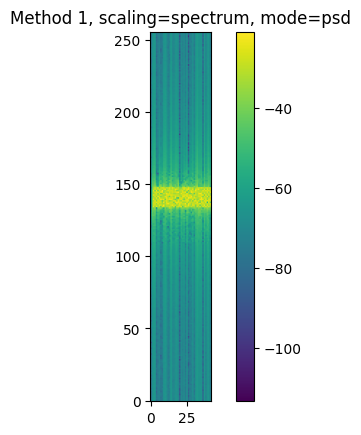


Method 1, scipy.spectrogram(scaling=spectrum, mode=psd)

Avg power spectrogram = -16.407647132873535


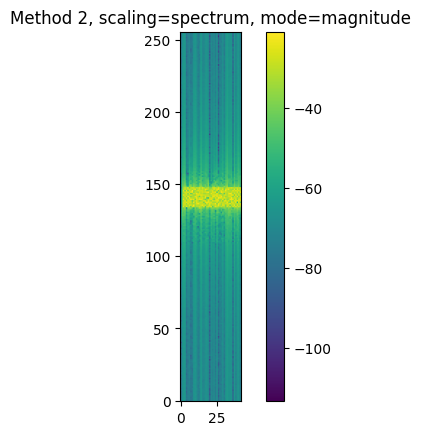


Method 2, scipy.spectrogram(scaling=spectrum, mode=magnitude)

Avg power spectrogram = -16.40764832496643


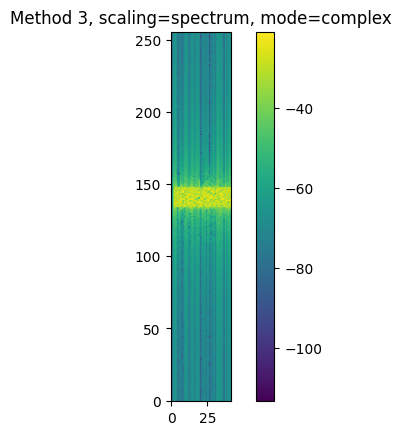


Method 3, scipy.spectrogram(scaling=spectrum, mode=complex)

Avg power spectrogram = -16.40764832496643


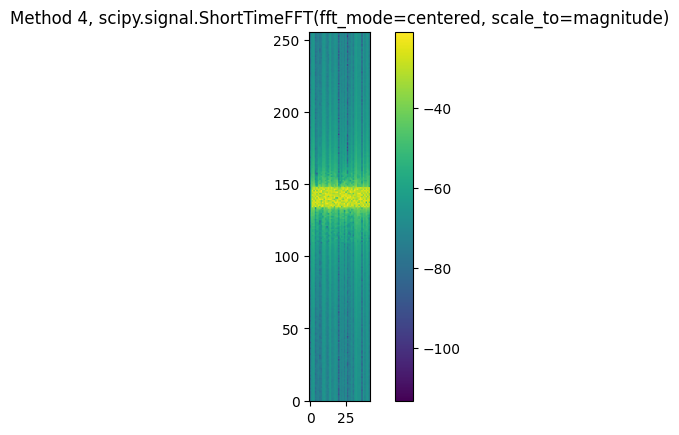


Method 4, scipy.signal.ShortTimeFFT(fft_mode=centered, scale_to=magnitude)

Avg power spectrogram = -16.40764725853183
upper_idx=177, lower_idx=106
Sxx.shape[0]=256


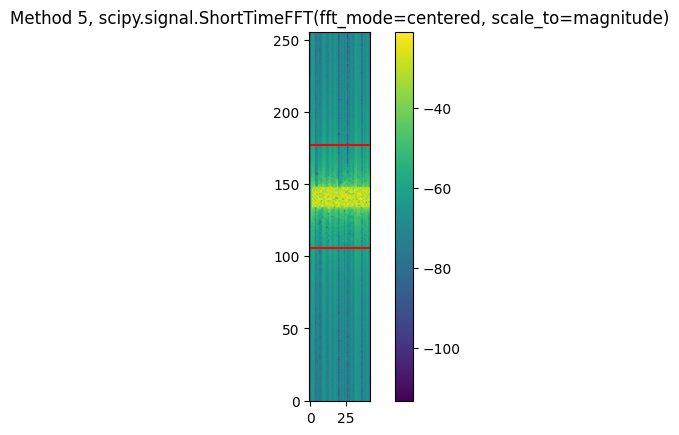


Method 5, scipy.signal.ShortTimeFFT(fft_mode=centered, scale_to=magnitude)

Avg power spectrogram = -16.40764725853183
signal_power_db=-16.418011027565242, noise_power_db=-42.635493968070875
total_power=-16.40764725853183
snr_db=26.217482940505633, snr_linear=418.550913426658, snr2=26.207094380762356
welch_signal_power_db=-16.41801118850708, welch_noise_power_db=-42.63549327850342


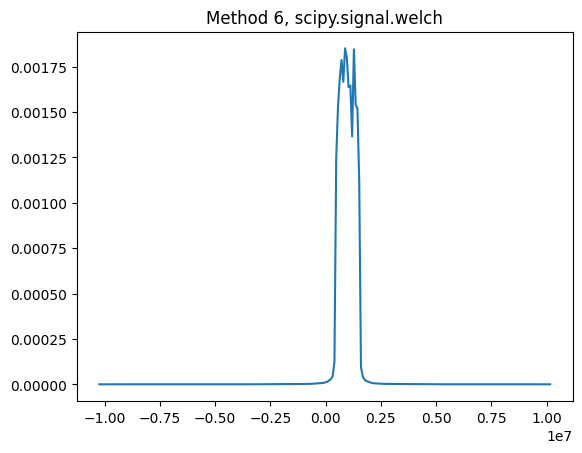


Method 6, scipy.signal.welch



(-16.418011027565242,
 -42.635493968070875,
 26.217482940505633,
 26.207094380762356)

In [122]:
get_power_spectrogram(iq_samples, sample_rate, 256, annotation, tuning_frequency, verbose=True)

In [93]:
sample_rate = data_obj.metadata["global"]["core:sample_rate"]
tuning_frequency = data_obj.metadata["captures"][0]["core:frequency"]
for i in range(10):
    annotation = data_obj.sigmf_obj.get_annotations()[i]
    iq_samples = get_annotation_samples(data_obj, annotation)
    signal_power, noise_power, snr, snr2 = get_power_spectrogram(iq_samples, sample_rate, 256, annotation, tuning_frequency, verbose=False)
    print(f"{i=}, {data_obj.sigmf_obj.get_annotations()[i]['core:label']}, {signal_power=}, {noise_power=}, {snr=}, {snr2=}")

upper_idx=240, lower_idx=16
Sxx.shape[0]=256
i=0, mini2_video, signal_power=-24.38874795953527, noise_power=-47.38528758195419, snr=22.99653962241892, snr2=22.974701172255514
upper_idx=240, lower_idx=16
Sxx.shape[0]=256
i=1, mini2_video, signal_power=-24.363572960206046, noise_power=-47.57630905696584, snr=23.212736096759794, snr2=23.191960712905924
upper_idx=240, lower_idx=16
Sxx.shape[0]=256
i=2, mini2_video, signal_power=-24.409451558470565, noise_power=-47.61442817550022, snr=23.204976617029658, snr2=23.1841639917392
upper_idx=240, lower_idx=16
Sxx.shape[0]=256
i=3, mini2_video, signal_power=-24.475922150779805, noise_power=-47.722086616252206, snr=23.2461644654724, snr2=23.225548758036787
upper_idx=177, lower_idx=106
Sxx.shape[0]=256
i=4, mini2_telem, signal_power=-16.418011027565242, noise_power=-42.635493968070875, snr=26.217482940505633, snr2=26.207094380762356
upper_idx=240, lower_idx=16
Sxx.shape[0]=256
i=5, mini2_video, signal_power=-24.523693030912636, noise_power=-48.25135

In [ ]:
#    Avg power spectrogram = -34.85135316848755
# 1. Avg power spectrogram = -34.85135237006511
# 2. Avg power spectrogram = -35.267020197850925
# 3. Avg power spectrogram = -35.267020197850925

In [15]:
fft_lens = [32, 64, 128, 256, 512, 1024, 2048]

powers = []
for f in fft_lens: 
    p = get_power_spectrogram(iq_samples, sample_rate, f, verbose=False)
    powers.append(p)
    print(f"fft_len = {f}, power_estimate = {p}")



SFT.p_min=0, SFT.p_max(len(iq_samples))=689
p0=0, p1=687,  k_offset=16
fft_len = 32, power_estimate = -24.383972533977357
SFT.p_min=0, SFT.p_max(len(iq_samples))=345
p0=0, p1=343,  k_offset=32
fft_len = 64, power_estimate = -24.377647483001397
SFT.p_min=0, SFT.p_max(len(iq_samples))=173
p0=0, p1=171,  k_offset=64
fft_len = 128, power_estimate = -24.365006570802628
SFT.p_min=0, SFT.p_max(len(iq_samples))=87
p0=0, p1=85,  k_offset=128
fft_len = 256, power_estimate = -24.367018774568102
SFT.p_min=0, SFT.p_max(len(iq_samples))=44
p0=0, p1=42,  k_offset=256
fft_len = 512, power_estimate = -24.372761498502314
SFT.p_min=0, SFT.p_max(len(iq_samples))=22
p0=0, p1=21,  k_offset=512
fft_len = 1024, power_estimate = -24.372761498502314
SFT.p_min=0, SFT.p_max(len(iq_samples))=12
p0=0, p1=10,  k_offset=1024
fft_len = 2048, power_estimate = -24.396755856152026


In [80]:
# psd
# (X*X) / N**2

# complex 
# X/N

# magnitude
# abs(X/N)